# Model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import torchvision.models as models
import torchfunc
from pytorch_hsv import HSVLoss

from sklearn import metrics
from sklearn.metrics import classification_report
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score

import copy
from PIL import Image
import os
import cv2

import gdown
from tqdm import tqdm
from skimage import io

import warnings
import shutil
import glob

from focal_loss.focal_loss import FocalLoss

In [2]:
warnings.filterwarnings("always")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sns.set_style("whitegrid")
sns.color_palette("flare")

torchfunc.cuda.reset()

In [46]:
LABELS = pd.read_csv(r'ClearLabels.csv', index_col = [0])

In [47]:
PATHS = []
for file_path in tqdm(glob.glob(r"D:\Diabetic Retinopathy\IOGEN_DATASET\dataset\train_prep5" + "/*")):
    PATHS.append(file_path)

100%|█████████████████████████████████████████████████████████████████████████| 7902/7902 [00:00<00:00, 3961677.05it/s]


In [48]:
PATHS.sort()
LABELS = LABELS.sort_index()
LABELS['path'] = PATHS

In [49]:
TRAIN_VAL_LABELS = LABELS['level'].to_dict()

Здесь выбраны наиболее частые техники аугментации. В частности, можно было добавить повороты, изменение насыщенности, резкости и т.д, но они не давали явного прироста к метрикам. Поэтому я остановился на простых вертикальных и горизонтальных флипах. Также мы делаем center crop и нормализуем изображения для использования pretrained моделей. Подробно в документации: https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0.

Замечу, что здесь я использовал стэкинг из 3 моделей: efficient_b0, vgg11, densenet201. Форматирование картинок для них одинаково.

In [50]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=mean, std=std), 
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=mean, std=std),
    ])
}              

Собственный класс, с помощью которого мы будем возвращать форматированные изображения с соответствующим лэйблом для батчей.

In [51]:
class EyesDataset(Dataset):
    def __init__(self, image_paths, LABELS, transform=False,):
        self.image_paths = image_paths
        self.labels = LABELS
        self.transform = transform
    

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        l = self.labels[os.path.basename(image_filepath).split('.')[0]]
        if self.transform is not None:
            image = Image.open(image_filepath)
            image = self.transform(image)

        return image, l

Простая функция, которая разбивает наш датасет так, чтобы в соотношение классов в тренировочной и валидационной совпадало. 

In [52]:
def equal_sampler(dataset, val_size):
    
    classes = dataset['level'].unique()
    train_path, val_path = [], []
    
    for c in classes:
        c_df = dataset[dataset['level'] == c]
        c_idx = c_df.sample(int((1-val_size)*c_df.shape[0]))
        c_idx = c_idx.index
        train_path.extend(c_df.loc[c_idx]['path'].values)
        c_df = c_df.drop(c_idx, axis = 0)
        val_path.extend(c_df['path'].values)
        
    return train_path, val_path

Разбиваем дату на тренировочную и валидацинную части. Далее создаем итерацию по соответствующим частям в виде батчей.

In [54]:
VAL_SIZE = 0.3
BATCH_SIZE = 16

train_image_paths, valid_image_paths = equal_sampler(LABELS, VAL_SIZE)

train_dataset = EyesDataset(train_image_paths, TRAIN_VAL_LABELS, transform['train'])
valid_dataset = EyesDataset(valid_image_paths, TRAIN_VAL_LABELS, transform['val'])

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True
)

Для интереса можно посмотреть как у нас представлены картинки после трансформации.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


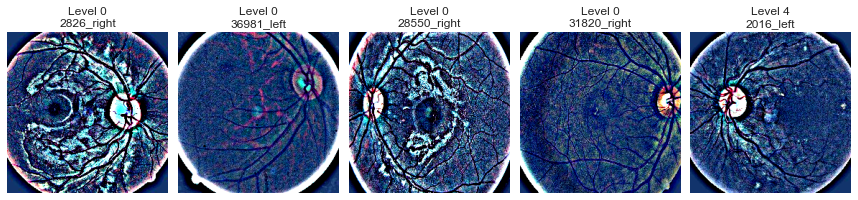

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


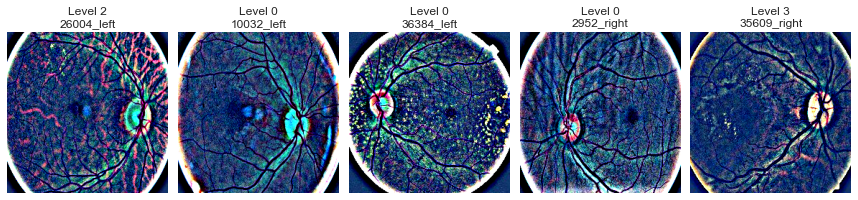

In [55]:
def visualize_augmentations(dataset, image_paths, idx=0, samples=5, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)
    rows = samples // cols

    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image.permute(1, 2, 0))
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title('Level '+ str(lab) + '\n' + image_paths[idx].split('\\')[-1][:-5])
    plt.tight_layout(pad=1)
    plt.show()

visualize_augmentations(train_dataset, train_image_paths, np.random.randint(1,len(train_image_paths)), random_img = True)
visualize_augmentations(valid_dataset, valid_image_paths, np.random.randint(1,len(valid_image_paths)), random_img = True)

Загружаем pretrained модели. В дальнейшем я остановлюсь на efficientnet_b0, vgg11, densenet201. Они показывали наиболее лучший перфоманс. Выбор именно таких моделей также связан с их популярностью в статьях по данной теме, в том числе при данных трансформациях.

In [91]:
model_ft1 = models.efficientnet_b0(pretrained = True)
for param in model_ft1.parameters():
    param.requires_grad = False
    
model_ft2 = models.resnext50_32x4d(pretrained=True)
for param in model_ft2.parameters():
    param.requires_grad = False
    
model_ft3 = models.densenet201(pretrained=True)
for param in model_ft3.parameters():
    param.requires_grad = False
    
model_ft4 = models.vgg11(pretrained = True)
for param in model_ft4.parameters():
    param.requires_grad = False

C:\Users\Алексей\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Алексей\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Алексей\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Алексей\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated si

In [92]:
effnetb0 = nn.Sequential(*(list(model_ft1.children())[:-1]))
resnext = nn.Sequential(*(list(model_ft2.children())[:-1]))
densenet = nn.Sequential(*(list(model_ft3.children())[:-1]))
vgg = nn.Sequential(*(list(model_ft4.children())[:-1]))

In [39]:
class EffModel(nn.Module):
    def __init__(self, feature_extractor, num_classes = 5):
        super(EffModel, self).__init__()

        self.conv_layers = nn.Sequential(
            feature_extractor,
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
    
            nn.Linear(1280, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64, num_classes),
            nn.Softmax(dim=-1)
            )

    def forward(self, x):
        conv_output = self.conv_layers(x)
        output = self.fc_layers(conv_output)
        return output

In [40]:
class ResXModel(nn.Module):
    def __init__(self, feature_extractor, num_classes = 5):
        super(ResXModel, self).__init__()

        self.conv_layers = nn.Sequential(
            feature_extractor,
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(

            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        conv_output = self.conv_layers(x)
        output = self.fc_layers(conv_output)
        return output

In [93]:
class VGGModel(nn.Module):
    def __init__(self, feature_extractor, num_classes = 5):
        super(VGGModel, self).__init__()

        self.conv_layers = nn.Sequential(
            feature_extractor,
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(

            nn.Linear(25088, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64, num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        conv_output = self.conv_layers(x)
        output = self.fc_layers(conv_output)
        return output

In [107]:
class DensModel(nn.Module):
    def __init__(self, feature_extractor, num_classes = 5):
        super(DensModel, self).__init__()

        self.conv_layers = nn.Sequential(
            feature_extractor,
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(

            nn.Linear(94080, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            
#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512),
#             nn.LeakyReLU(),
#             nn.Dropout(0.5),
            
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.LeakyReLU(),
#             nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
                    
            nn.Linear(64, num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        conv_output = self.conv_layers(x)
        output = self.fc_layers(conv_output)
        return output

In [123]:
class CombinedModel(nn.Module):
    def __init__(self, model1, model2, model3):
        super(CombinedModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        
        self.softmax = nn.Softmax(dim = -1)
        
    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        
        out = (out1 + out2 + out3)/3
        return out
    
model = CombinedModel(VGGModel(vgg), DensModel(densenet), EffModel(effnetb0)).to(device)

In [124]:
summary(model, (3, 224, 224), verbose = False)

Layer (type:depth-idx)                        Output Shape              Param #
├─VGGModel: 1-1                               [-1, 5]                   --
|    └─Sequential: 2-1                        [-1, 25088]               --
|    |    └─Sequential: 3-1                   [-1, 512, 7, 7]           (9,220,480)
|    |    └─Flatten: 3-2                      [-1, 25088]               --
|    └─Sequential: 2-2                        [-1, 5]                   --
|    |    └─Linear: 3-3                       [-1, 256]                 6,422,784
|    |    └─BatchNorm1d: 3-4                  [-1, 256]                 512
|    |    └─LeakyReLU: 3-5                    [-1, 256]                 --
|    |    └─Dropout: 3-6                      [-1, 256]                 --
|    |    └─Linear: 3-7                       [-1, 64]                  16,448
|    |    └─BatchNorm1d: 3-8                  [-1, 64]                  128
|    |    └─LeakyReLU: 3-9                    [-1, 64]                  -

В силу дисбалансса классов я создал веса для каждого класса для их учета в loss функции.

In [125]:
frequency = LABELS['level'].to_numpy()
frequency = np.unique(frequency, return_counts = True)
class_weigths = frequency[1].sum() / frequency[1]

In [126]:
class_weigths = class_weigths / class_weigths.sum()
class_weigths = torch.from_numpy(class_weigths).to(device)
class_weigths

tensor([0.0119, 0.1325, 0.0586, 0.3479, 0.4490], device='cuda:0',
       dtype=torch.float64)

Focal loss, обычно, показывает отличные результаты при работе с несбалансированными данными. При своей работе я остановился на нём. Adam - популярный и классический выбор. Шаг изменения lr был подобран вручную.

In [127]:
loss_fn = FocalLoss(weights=class_weigths, gamma = 2)
optimizer = optim.Adam(params=model.parameters(), lr=1e-4, weight_decay = 1e-2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.5)

In [128]:
n_epochs = 50
train_losses, valid_losses = [], []
acc_scores = []
f1_scores = []
p_scores = []
r_scores = []
base_f1 = 0.5

for epoch in range(n_epochs):

    print(f'➤ EPOCH {epoch+1}/{n_epochs}.\n')
    
    running_loss = 0
    model.train()

    for inputs, labels in tqdm(train_loader, desc = 'Training loop'):
        
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)

        loss = loss_fn(y_pred, labels)
        running_loss += loss.item() * inputs.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss = running_loss/len(train_loader.sampler)
    train_losses.append(running_loss)

    all_pred_labels = []
    all_true_labels = []
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc = 'Validation loop'):

            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)

            loss = loss_fn(y_pred, labels)
            valid_loss += loss.item() * inputs.size(0)

            _, pred_labels = torch.max(y_pred, 1)

            labels = labels.cpu().detach().numpy()
            pred_labels = pred_labels.cpu().detach().numpy()

            all_pred_labels.extend(pred_labels)
            all_true_labels.extend(labels)
            
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)
    exp_lr_scheduler.step()

    acc = metrics.balanced_accuracy_score(all_true_labels, all_pred_labels)
    f1 = metrics.f1_score(all_true_labels, all_pred_labels, average = 'weighted')
    P = metrics.precision_score(all_true_labels, all_pred_labels, average = 'weighted')
    R = metrics.recall_score(all_true_labels, all_pred_labels, average = 'weighted')
    rep = metrics.classification_report(all_true_labels, all_pred_labels)
    
        
    acc_scores.append(acc)
    f1_scores.append(f1)
    p_scores.append(P)
    r_scores.append(R)
    
    print('------------------------------')
    print("Weighted accuracy = {:.5f}.".format(acc))
    print("Weighted F1-score = {:.5f}.".format(f1))
    print("Precision = {:.5f}.".format(P))
    print("Recall = {:.5f}.".format(R))
    print('------------------------------')
    print(rep)
    print('------------------------------')
    print("Train loss = {:.5f}.".format(running_loss))
    print("Validation loss = {:.5f}.\n".format(valid_loss))
    
    if f1 > base_f1:
        torch.save(model.state_dict(), 'model_weights.pth')
        base_f1 = f1
        print('WEIGHTS SAVED.')

➤ EPOCH 1/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


------------------------------
Weighted accuracy = 0.38632.
Weighted F1-score = 0.24262.
Precision = 0.69557.
Recall = 0.20228.
------------------------------
              precision    recall  f1-score   support

           0       0.91      0.17      0.28      1751
           1       0.10      0.49      0.16       158
           2       0.11      0.15      0.13       357
           3       0.09      0.42      0.15        60
           4       0.07      0.70      0.13        47

    accuracy                           0.20      2373
   macro avg       0.26      0.39      0.17      2373
weighted avg       0.70      0.20      0.24      2373

------------------------------
Train loss = 0.96477.
Validation loss = 0.90789.

➤ EPOCH 2/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


------------------------------
Weighted accuracy = 0.44438.
Weighted F1-score = 0.39934.
Precision = 0.69679.
Recall = 0.33291.
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.32      0.47      1751
           1       0.11      0.49      0.18       158
           2       0.18      0.27      0.22       357
           3       0.15      0.53      0.24        60
           4       0.10      0.62      0.17        47

    accuracy                           0.33      2373
   macro avg       0.29      0.44      0.25      2373
weighted avg       0.70      0.33      0.40      2373

------------------------------
Train loss = 0.84454.
Validation loss = 0.84476.

➤ EPOCH 3/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


------------------------------
Weighted accuracy = 0.45338.
Weighted F1-score = 0.49237.
Precision = 0.67908.
Recall = 0.42056.
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.46      0.60      1751
           1       0.09      0.35      0.15       158
           2       0.20      0.22      0.21       357
           3       0.19      0.47      0.27        60
           4       0.12      0.77      0.21        47

    accuracy                           0.42      2373
   macro avg       0.29      0.45      0.29      2373
weighted avg       0.68      0.42      0.49      2373

------------------------------
Train loss = 0.77081.
Validation loss = 0.81257.

➤ EPOCH 4/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.39it/s]


------------------------------
Weighted accuracy = 0.47784.
Weighted F1-score = 0.54849.
Precision = 0.69000.
Recall = 0.48504.
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.53      0.65      1751
           1       0.11      0.37      0.16       158
           2       0.25      0.30      0.27       357
           3       0.26      0.52      0.35        60
           4       0.15      0.68      0.25        47

    accuracy                           0.49      2373
   macro avg       0.33      0.48      0.34      2373
weighted avg       0.69      0.49      0.55      2373

------------------------------
Train loss = 0.74123.
Validation loss = 0.75340.



C:\Users\Алексей\lib\site-packages\torch\storage.py:460: ResourceWarning: unclosed file <_io.BufferedReader name='D:\\Diabetic Retinopathy\\IOGEN_DATASET\\dataset\\train_prep5\\39383_left.jpeg'>
  self.dtype = dtype
C:\Users\Алексей\lib\site-packages\torch\storage.py:460: ResourceWarning: unclosed file <_io.BufferedReader name='D:\\Diabetic Retinopathy\\IOGEN_DATASET\\dataset\\train_prep5\\10791_left.jpeg'>
  self.dtype = dtype


WEIGHTS SAVED.
➤ EPOCH 5/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


------------------------------
Weighted accuracy = 0.48916.
Weighted F1-score = 0.55598.
Precision = 0.69426.
Recall = 0.49389.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.54      0.67      1751
           1       0.10      0.30      0.15       158
           2       0.24      0.30      0.27       357
           3       0.21      0.67      0.32        60
           4       0.15      0.64      0.25        47

    accuracy                           0.49      2373
   macro avg       0.32      0.49      0.33      2373
weighted avg       0.69      0.49      0.56      2373

------------------------------
Train loss = 0.67263.
Validation loss = 0.73206.

WEIGHTS SAVED.
➤ EPOCH 6/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.48394.
Weighted F1-score = 0.56716.
Precision = 0.69821.
Recall = 0.50695.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.55      0.68      1751
           1       0.12      0.39      0.18       158
           2       0.26      0.31      0.28       357
           3       0.22      0.62      0.33        60
           4       0.18      0.55      0.27        47

    accuracy                           0.51      2373
   macro avg       0.33      0.48      0.35      2373
weighted avg       0.70      0.51      0.57      2373

------------------------------
Train loss = 0.65976.
Validation loss = 0.72627.

WEIGHTS SAVED.
➤ EPOCH 7/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.50207.
Weighted F1-score = 0.58732.
Precision = 0.70912.
Recall = 0.53139.
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.57      0.69      1751
           1       0.12      0.36      0.19       158
           2       0.29      0.40      0.34       357
           3       0.23      0.58      0.33        60
           4       0.21      0.60      0.31        47

    accuracy                           0.53      2373
   macro avg       0.35      0.50      0.37      2373
weighted avg       0.71      0.53      0.59      2373

------------------------------
Train loss = 0.63061.
Validation loss = 0.71481.

WEIGHTS SAVED.
➤ EPOCH 8/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.48it/s]


------------------------------
Weighted accuracy = 0.48047.
Weighted F1-score = 0.58669.
Precision = 0.69466.
Recall = 0.53350.
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.59      0.70      1751
           1       0.12      0.27      0.17       158
           2       0.27      0.37      0.31       357
           3       0.18      0.65      0.28        60
           4       0.20      0.53      0.29        47

    accuracy                           0.53      2373
   macro avg       0.33      0.48      0.35      2373
weighted avg       0.69      0.53      0.59      2373

------------------------------
Train loss = 0.60575.
Validation loss = 0.71225.

➤ EPOCH 9/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.48it/s]


------------------------------
Weighted accuracy = 0.51601.
Weighted F1-score = 0.58582.
Precision = 0.70866.
Recall = 0.53139.
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.57      0.69      1751
           1       0.13      0.33      0.18       158
           2       0.27      0.42      0.33       357
           3       0.26      0.65      0.37        60
           4       0.21      0.62      0.32        47

    accuracy                           0.53      2373
   macro avg       0.35      0.52      0.38      2373
weighted avg       0.71      0.53      0.59      2373

------------------------------
Train loss = 0.56349.
Validation loss = 0.68580.

➤ EPOCH 10/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.48it/s]


------------------------------
Weighted accuracy = 0.49158.
Weighted F1-score = 0.58540.
Precision = 0.70888.
Recall = 0.52802.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.57      0.69      1751
           1       0.12      0.42      0.19       158
           2       0.30      0.39      0.34       357
           3       0.28      0.55      0.37        60
           4       0.22      0.53      0.31        47

    accuracy                           0.53      2373
   macro avg       0.36      0.49      0.38      2373
weighted avg       0.71      0.53      0.59      2373

------------------------------
Train loss = 0.56165.
Validation loss = 0.69331.

➤ EPOCH 11/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.48859.
Weighted F1-score = 0.57935.
Precision = 0.70429.
Recall = 0.52339.
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.56      0.69      1751
           1       0.13      0.32      0.18       158
           2       0.25      0.41      0.31       357
           3       0.24      0.58      0.34        60
           4       0.20      0.57      0.30        47

    accuracy                           0.52      2373
   macro avg       0.34      0.49      0.36      2373
weighted avg       0.70      0.52      0.58      2373

------------------------------
Train loss = 0.53473.
Validation loss = 0.68674.

➤ EPOCH 12/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.49399.
Weighted F1-score = 0.60463.
Precision = 0.70861.
Recall = 0.55373.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1751
           1       0.13      0.38      0.20       158
           2       0.30      0.42      0.35       357
           3       0.26      0.52      0.35        60
           4       0.26      0.55      0.35        47

    accuracy                           0.55      2373
   macro avg       0.37      0.49      0.39      2373
weighted avg       0.71      0.55      0.60      2373

------------------------------
Train loss = 0.51510.
Validation loss = 0.68880.

WEIGHTS SAVED.
➤ EPOCH 13/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.50617.
Weighted F1-score = 0.58136.
Precision = 0.70966.
Recall = 0.52339.
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.56      0.68      1751
           1       0.12      0.39      0.18       158
           2       0.30      0.39      0.34       357
           3       0.24      0.62      0.34        60
           4       0.25      0.57      0.35        47

    accuracy                           0.52      2373
   macro avg       0.36      0.51      0.38      2373
weighted avg       0.71      0.52      0.58      2373

------------------------------
Train loss = 0.48306.
Validation loss = 0.68873.

➤ EPOCH 14/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.42it/s]


------------------------------
Weighted accuracy = 0.47090.
Weighted F1-score = 0.58500.
Precision = 0.70197.
Recall = 0.52929.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.57      0.69      1751
           1       0.12      0.38      0.18       158
           2       0.29      0.40      0.33       357
           3       0.25      0.53      0.34        60
           4       0.25      0.47      0.32        47

    accuracy                           0.53      2373
   macro avg       0.35      0.47      0.37      2373
weighted avg       0.70      0.53      0.58      2373

------------------------------
Train loss = 0.48556.
Validation loss = 0.67762.

➤ EPOCH 15/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.48717.
Weighted F1-score = 0.61549.
Precision = 0.71160.
Recall = 0.56595.
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.62      0.72      1751
           1       0.13      0.34      0.19       158
           2       0.30      0.42      0.35       357
           3       0.27      0.50      0.35        60
           4       0.25      0.55      0.34        47

    accuracy                           0.57      2373
   macro avg       0.36      0.49      0.39      2373
weighted avg       0.71      0.57      0.62      2373

------------------------------
Train loss = 0.45462.
Validation loss = 0.67078.

WEIGHTS SAVED.
➤ EPOCH 16/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.42it/s]


------------------------------
Weighted accuracy = 0.50256.
Weighted F1-score = 0.61620.
Precision = 0.70931.
Recall = 0.56764.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.62      0.73      1751
           1       0.14      0.37      0.20       158
           2       0.31      0.38      0.34       357
           3       0.25      0.50      0.33        60
           4       0.23      0.64      0.34        47

    accuracy                           0.57      2373
   macro avg       0.36      0.50      0.39      2373
weighted avg       0.71      0.57      0.62      2373

------------------------------
Train loss = 0.46290.
Validation loss = 0.68038.

WEIGHTS SAVED.
➤ EPOCH 17/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.49431.
Weighted F1-score = 0.60468.
Precision = 0.70788.
Recall = 0.55331.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1751
           1       0.12      0.33      0.18       158
           2       0.30      0.43      0.36       357
           3       0.24      0.50      0.32        60
           4       0.25      0.62      0.35        47

    accuracy                           0.55      2373
   macro avg       0.36      0.49      0.38      2373
weighted avg       0.71      0.55      0.60      2373

------------------------------
Train loss = 0.44631.
Validation loss = 0.67002.

➤ EPOCH 18/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.49488.
Weighted F1-score = 0.61905.
Precision = 0.71659.
Recall = 0.57016.
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.62      0.72      1751
           1       0.14      0.37      0.20       158
           2       0.31      0.45      0.36       357
           3       0.28      0.55      0.37        60
           4       0.28      0.49      0.36        47

    accuracy                           0.57      2373
   macro avg       0.38      0.49      0.40      2373
weighted avg       0.72      0.57      0.62      2373

------------------------------
Train loss = 0.44449.
Validation loss = 0.67063.

WEIGHTS SAVED.
➤ EPOCH 19/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.47814.
Weighted F1-score = 0.61988.
Precision = 0.70950.
Recall = 0.57269.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1751
           1       0.13      0.34      0.19       158
           2       0.30      0.43      0.35       357
           3       0.25      0.55      0.34        60
           4       0.29      0.45      0.35        47

    accuracy                           0.57      2373
   macro avg       0.37      0.48      0.39      2373
weighted avg       0.71      0.57      0.62      2373

------------------------------
Train loss = 0.42628.
Validation loss = 0.67539.

WEIGHTS SAVED.
➤ EPOCH 20/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.49372.
Weighted F1-score = 0.63243.
Precision = 0.70640.
Recall = 0.59039.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.66      0.75      1751
           1       0.14      0.28      0.18       158
           2       0.30      0.39      0.34       357
           3       0.25      0.52      0.34        60
           4       0.24      0.62      0.34        47

    accuracy                           0.59      2373
   macro avg       0.36      0.49      0.39      2373
weighted avg       0.71      0.59      0.63      2373

------------------------------
Train loss = 0.41849.
Validation loss = 0.68706.

WEIGHTS SAVED.
➤ EPOCH 21/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.47872.
Weighted F1-score = 0.63340.
Precision = 0.70708.
Recall = 0.59081.
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.66      0.75      1751
           1       0.13      0.30      0.18       158
           2       0.32      0.42      0.37       357
           3       0.27      0.50      0.35        60
           4       0.27      0.51      0.36        47

    accuracy                           0.59      2373
   macro avg       0.37      0.48      0.40      2373
weighted avg       0.71      0.59      0.63      2373

------------------------------
Train loss = 0.42490.
Validation loss = 0.66879.

WEIGHTS SAVED.
➤ EPOCH 22/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.48551.
Weighted F1-score = 0.61966.
Precision = 0.70946.
Recall = 0.57143.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.62      0.73      1751
           1       0.13      0.39      0.20       158
           2       0.32      0.41      0.36       357
           3       0.29      0.47      0.35        60
           4       0.29      0.53      0.38        47

    accuracy                           0.57      2373
   macro avg       0.38      0.49      0.40      2373
weighted avg       0.71      0.57      0.62      2373

------------------------------
Train loss = 0.42167.
Validation loss = 0.67387.

➤ EPOCH 23/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.48450.
Weighted F1-score = 0.62030.
Precision = 0.70766.
Recall = 0.57438.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1751
           1       0.13      0.32      0.19       158
           2       0.30      0.45      0.36       357
           3       0.28      0.45      0.34        60
           4       0.28      0.57      0.38        47

    accuracy                           0.57      2373
   macro avg       0.37      0.48      0.40      2373
weighted avg       0.71      0.57      0.62      2373

------------------------------
Train loss = 0.40694.
Validation loss = 0.68536.

➤ EPOCH 24/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.48751.
Weighted F1-score = 0.61879.
Precision = 0.70402.
Recall = 0.57185.
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.63      0.73      1751
           1       0.12      0.32      0.18       158
           2       0.31      0.40      0.35       357
           3       0.25      0.52      0.34        60
           4       0.29      0.57      0.38        47

    accuracy                           0.57      2373
   macro avg       0.37      0.49      0.39      2373
weighted avg       0.70      0.57      0.62      2373

------------------------------
Train loss = 0.41202.
Validation loss = 0.67259.

➤ EPOCH 25/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.48421.
Weighted F1-score = 0.64407.
Precision = 0.70561.
Recall = 0.60683.
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1751
           1       0.13      0.27      0.18       158
           2       0.32      0.42      0.36       357
           3       0.29      0.45      0.36        60
           4       0.28      0.60      0.38        47

    accuracy                           0.61      2373
   macro avg       0.38      0.48      0.41      2373
weighted avg       0.71      0.61      0.64      2373

------------------------------
Train loss = 0.40977.
Validation loss = 0.66700.

WEIGHTS SAVED.
➤ EPOCH 26/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.49570.
Weighted F1-score = 0.60655.
Precision = 0.70902.
Recall = 0.55584.
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.60      0.71      1751
           1       0.13      0.32      0.18       158
           2       0.29      0.42      0.35       357
           3       0.26      0.53      0.35        60
           4       0.22      0.60      0.32        47

    accuracy                           0.56      2373
   macro avg       0.35      0.50      0.38      2373
weighted avg       0.71      0.56      0.61      2373

------------------------------
Train loss = 0.40239.
Validation loss = 0.67382.

➤ EPOCH 27/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.46565.
Weighted F1-score = 0.64076.
Precision = 0.70422.
Recall = 0.60219.
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1751
           1       0.12      0.27      0.17       158
           2       0.31      0.43      0.36       357
           3       0.31      0.40      0.35        60
           4       0.29      0.55      0.38        47

    accuracy                           0.60      2373
   macro avg       0.38      0.47      0.40      2373
weighted avg       0.70      0.60      0.64      2373

------------------------------
Train loss = 0.39467.
Validation loss = 0.67444.

➤ EPOCH 28/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.49it/s]


------------------------------
Weighted accuracy = 0.48496.
Weighted F1-score = 0.62210.
Precision = 0.71221.
Recall = 0.57438.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1751
           1       0.13      0.34      0.18       158
           2       0.32      0.45      0.37       357
           3       0.29      0.48      0.36        60
           4       0.27      0.53      0.36        47

    accuracy                           0.57      2373
   macro avg       0.37      0.48      0.40      2373
weighted avg       0.71      0.57      0.62      2373

------------------------------
Train loss = 0.39206.
Validation loss = 0.66984.

➤ EPOCH 29/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.48131.
Weighted F1-score = 0.62100.
Precision = 0.70936.
Recall = 0.57480.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1751
           1       0.13      0.30      0.18       158
           2       0.31      0.46      0.37       357
           3       0.27      0.40      0.32        60
           4       0.26      0.62      0.36        47

    accuracy                           0.57      2373
   macro avg       0.37      0.48      0.39      2373
weighted avg       0.71      0.57      0.62      2373

------------------------------
Train loss = 0.40170.
Validation loss = 0.68372.

➤ EPOCH 30/50.



Validation loop: 100%|███████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


------------------------------
Weighted accuracy = 0.49527.
Weighted F1-score = 0.62197.
Precision = 0.70622.
Recall = 0.57606.
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.64      0.73      1751
           1       0.12      0.30      0.17       158
           2       0.31      0.41      0.35       357
           3       0.26      0.52      0.35        60
           4       0.26      0.62      0.36        47

    accuracy                           0.58      2373
   macro avg       0.36      0.50      0.39      2373
weighted avg       0.71      0.58      0.62      2373

------------------------------
Train loss = 0.39768.
Validation loss = 0.67116.

➤ EPOCH 31/50.



Training loop:  13%|████████▌                                                         | 45/346 [00:14<01:34,  3.19it/s]


KeyboardInterrupt: 

In [133]:
print('Best model has weighted F1-score = {:.5f}.'.format(base_f1))

Best model has weighted F1-score = 0.64407.


График lossа показывает нам сильный underfit примерно после 8 эпохи. Решить проблему можно несколькими способами:
1. Стандартизировать все данные. Можем заметить, что некоторые картинки у нас не всегда обрезались по краям при процессинге (также остаются выступы из окружности).
2. Попробовать использовать другие техники удаления шума.
3. Обучаться на расширенном датасете (увеличивало F1 примерно до 0.67). Не сильно. Основная причина всех бед - использованный препроцессинг не дает стандартизацию всех картинок.
4. Добавить повороты картинок (возможно, также добавить фильтры).

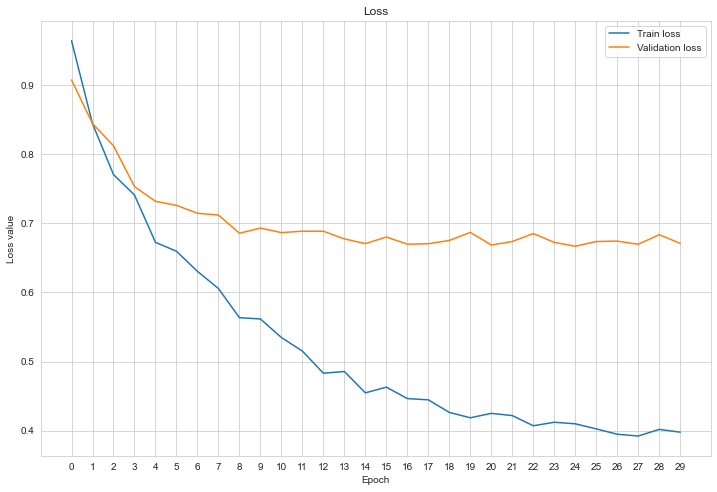

In [188]:
plt.figure(figsize = (12,8))
plt.plot(train_losses, label = 'Train loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.xticks(np.arange(0, 30, step=1))
plt.title('Loss')
plt.legend()

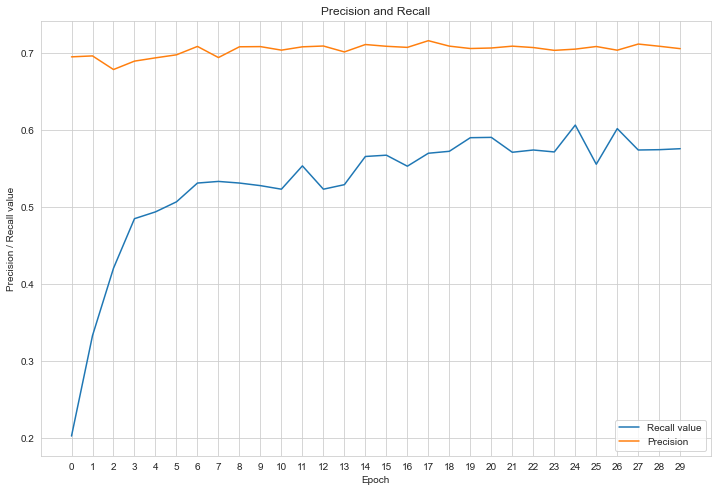

In [150]:
plt.figure(figsize = (12,8))
plt.plot(r_scores, label = 'Recall value')
plt.plot(p_scores, label = 'Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision / Recall value')
plt.xticks(np.arange(0, 30, step=1))
plt.title('Precision and Recall')
plt.legend()

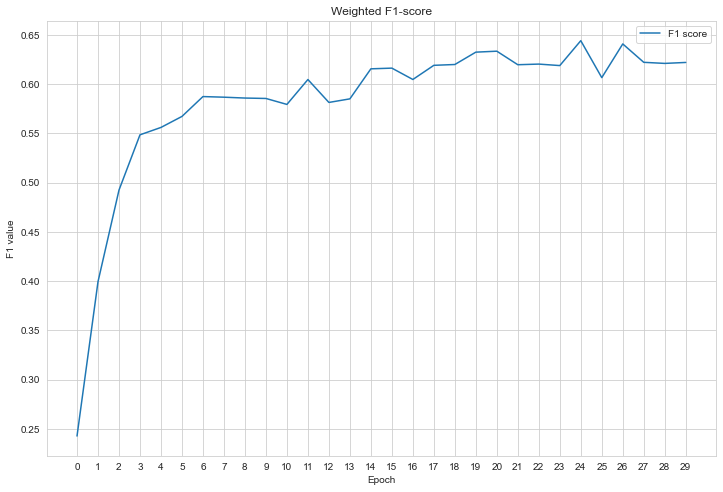

In [144]:
plt.figure(figsize = (12,8))
plt.plot(f1_scores, label = 'F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 value')
plt.xticks(np.arange(0, 30, step=1))
plt.title('Weighted F1-score')
plt.legend()

# Predict Test Data

Здесь я использовал тестовую выборку из другого датасета: https://www.kaggle.com/datasets/aaryapatel98/indian-diabetic-retinopathy-image-dataset.

In [158]:
TEST_LABELS_DF = pd.read_csv(r"D:\Diabetic Retinopathy\INDIAN_DATASET\2. Groundtruths\Testing Labels.csv", index_col = [0])
TEST_LABELS_DF.head()

,level,Risk of macular edema
image,,
IDRiD_001,4,0
IDRiD_002,4,1
IDRiD_003,4,0
IDRiD_004,4,0
IDRiD_005,4,1


In [159]:
TEST_LABELS_DF.shape

(103, 2)

In [160]:
TEST_LABELS_DF['level'].value_counts().sort_index()

0    34
1     5
2    32
3    19
4    13
Name: level, dtype: int64

In [172]:
TEST_PATHS = []
for file_path in tqdm(glob.glob(r'D:\Diabetic Retinopathy\INDIAN_DATASET\Original Images\Test_prep5' + "/*")):
    TEST_PATHS.append(file_path)

100%|████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<?, ?it/s]


In [173]:
TEST_PATHS.sort()

In [174]:
TEST_LABELS_DF = TEST_LABELS_DF.sort_index()

In [175]:
TEST_LABELS_DF['path'] = TEST_PATHS

In [176]:
TEST_LABELS = TEST_LABELS_DF['level'].to_dict()

In [177]:
test_dataset = EyesDataset(TEST_PATHS, TEST_LABELS, transform['test'])

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [178]:
model = CombinedModel(VGGModel(vgg), DensModel(densenet), EffModel(effnetb0)).to(device)
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [180]:
all_pred_labels = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc = 'Test loop'):

        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)

        loss = loss_fn(y_pred, labels)
        valid_loss += loss.item() * inputs.size(0)

        _, pred_labels = torch.max(y_pred, 1)

        labels = labels.cpu().detach().numpy()
        pred_labels = pred_labels.cpu().detach().numpy()

        all_pred_labels.extend(pred_labels)
        all_true_labels.extend(labels)

    acc = metrics.balanced_accuracy_score(all_true_labels, all_pred_labels)
    f1 = metrics.f1_score(all_true_labels, all_pred_labels, average = 'weighted')
    P = metrics.precision_score(all_true_labels, all_pred_labels, average = 'weighted')
    R = metrics.recall_score(all_true_labels, all_pred_labels, average = 'weighted')
    rep = metrics.classification_report(all_true_labels, all_pred_labels)
    
    print('------------------------------')
    print("Weighted accuracy = {:.5f}.".format(acc))
    print("Weighted F1-score = {:.5f}.".format(f1))
    print("Precision = {:.5f}.".format(P))
    print("Recall = {:.5f}.".format(R))
    print('------------------------------')
    print(rep)

Test loop: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.30it/s]

------------------------------
Weighted accuracy = 0.41107.
Weighted F1-score = 0.37008.
Precision = 0.57654.
Recall = 0.35922.
------------------------------
              precision    recall  f1-score   support

           0       0.80      0.24      0.36        34
           1       0.09      0.40      0.15         5
           2       0.67      0.25      0.36        32
           3       0.31      0.63      0.41        19
           4       0.35      0.54      0.42        13

    accuracy                           0.36       103
   macro avg       0.44      0.41      0.34       103
weighted avg       0.58      0.36      0.37       103



Тест на сторонней метрике показал достаточно низкое значение F1. Автор полагает, что это также является последствием неоптимального препроцессинга для различных картинок и низкой выборке. Тем не менее, работа над данным алгоритмом продолжится и после сдачи дз :).